In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel
from inference.frequentist.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 1],
            "activation": "tanh",
            "dim_reduction": False,
            "inference": "q_regr",
            "lr": 0.03,
            "num_iterations": 1000,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Quantile Regression

In [5]:
quantiles = [0.025*n for n in range(40)]
# quantiles = [0.025, 0.5, 0.975]
QR_torch_model = TorchModel(config.model_widths, config.activation, quantiles).to(device)

In [6]:
predictive, diagnostics = inference(config, QR_torch_model, None, X_train=train_embedding, Y_train=Ytr, 
                                    X_test=test_embedding, Y_test=Yte, num_samples=None, inference_name=None,
                                    quantiles=quantiles)

Epoch 1000: 100%|██████████| 1000/1000 [00:19<00:00, 50.07it/s, loss=0.108]


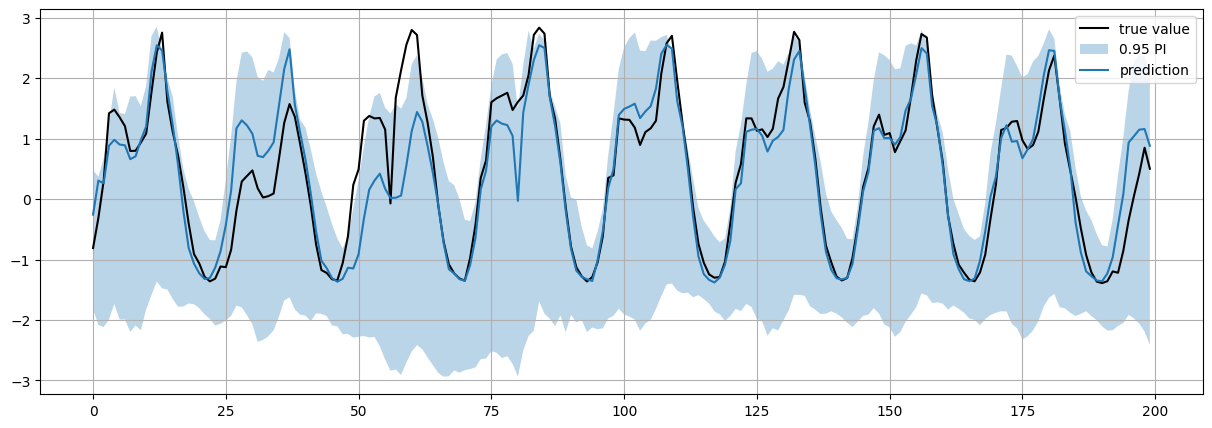

In [7]:
plot_forecast(predictive, Yte)

In [11]:
for k, v in diagnostics.items():
    print(k)

train_time
quantiles
avg_length
cal_error


In [8]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])

training time:  3.640625
calibration error:  0.12226531391367901
